# Semi-Gradient TD via Artificial Neural Network
We are going to show that semi-gradient non-linear function approximation does not gaurantee convergence. This is mainly due to non-stationarity of the target policy.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
import collections

In [2]:
class RandomWalk(gym.Env):
    def __init__(self, states:int):
        super(RandomWalk, self).__init__()

        self.states = states
        self.current_state = None

        self.observation_space = gym.spaces.Box(low=0, high=states, shape=(1,), dtype=np.int32)
        self.action_space = gym.spaces.Discrete(2)

        self.action_translation = [-1, 1]

    def reset(self, seed:int=None):
        self.current_state = self.states // 2
        return {'state':self.current_state}

    def is_terminated(self):
        return self.current_state in [0, self.states - 1]

    def step(self, action:int):
        if action >= len(self.action_translation):
            raise ValueError("Action is undefined!")

        if self.current_state is None:
            raise ValueError("Please reset the environment first")

        if self.is_terminated():
            return {'state': self.current_state, 'reward': 0, 'terminated':True}

        self.current_state += self.action_translation[action] * np.random.randint(1, 101)
        self.current_state = np.clip(self.current_state, 0, self.states - 1)

        reward = 0
        if self.is_terminated():
            reward = 1 if self.current_state == self.states - 1 else -1
        return {'state': self.current_state, 'reward': reward, 'terminated':self.is_terminated()}

## Define Value function approximator

In [3]:
class V_hat(nn.Module):
    def __init__(self, in_features:int=1):
        super(V_hat, self).__init__()
        self.layer1 = nn.Linear(in_features=in_features, out_features=4)
        self.layer2 = nn.Linear(in_features=4, out_features=8)
        self.layer3 = nn.Linear(in_features=8, out_features=16)
        self.o = nn.Linear(in_features=16, out_features=1)

    def forward(self, x:torch.Tensor):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.o(x)
        return x
    

class V_hat_linear(nn.Module):
    def __init__(self, in_features:int=1):
        super(V_hat_linear, self).__init__()
        self.o = nn.Linear(in_features=in_features, out_features=1, bias=False)

    def forward(self, x:torch.Tensor):
        x = self.o(x)
        return x

## Write the training loop

In [4]:
def get_features(state:int, groups:int, num_states:int):
    size_of_each = num_states // groups
    group = state // size_of_each
    x = torch.zeros((1, groups), dtype=torch.float32)
    x[0, group] = 1
    return x

In [5]:
def train_ann(
    v_hat:nn.Module,
    env:RandomWalk,
    groups:int,
    num_of_states:int,
    episodes:int=1,
    gamma:float=1.0,
    alpha:float=0.1,
    gt:np.ndarray=None
):
    history = []
    with tqdm(range(episodes), leave=True) as pbar:
        for episode in pbar:
            state = env.reset()['state']
            state = get_features(state, groups, num_of_states)
            
            while not env.is_terminated():
                action = int(np.random.choice([0, 1]))
                feedback = env.step(action)
                new_state = get_features(feedback['state'], groups, num_of_states)
                reward = torch.tensor(feedback['reward'])
                reward = reward.reshape((1, 1))

                if not env.is_terminated():
                    target = reward + gamma * v_hat(new_state)
                    target = target.detach()
                else:
                    target = reward
                loss = 0.5 * torch.float_power(target - v_hat(state), 2)
                v_hat.zero_grad()
                loss.backward()

                # Take the gradient
                with torch.no_grad():
                    for w in v_hat.parameters():
                        if w.grad is not None:
                            w.copy_(w - alpha * w.grad)
                state = new_state.detach()

            pbar.set_postfix({'loss':float(loss)})
            if gt is not None:
                states = torch.arange(0, num_of_states)
                per_group = num_of_states // groups
                states = (states // per_group)
                features = torch.eye(groups)[states]
                values = v_hat(features).detach().numpy()
                mae = np.abs(values[:, 0] - gt)
                history.append(mae.mean())


    return v_hat, history


In [6]:
num_of_states = 1000
groups = 10
gt = np.load("gt.npy")
v_hat_linear = V_hat_linear(groups)
random_walk = RandomWalk(num_of_states)
v_hat_linear, linear_history = train_ann(
    v_hat=v_hat_linear,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=1000,
    gamma=1.0,
    alpha=0.1,
    gt=gt
)

v_hat_nonlinear = V_hat(groups)
v_hat_nonlinear, nonlinear_history = train_ann(
    v_hat=v_hat_nonlinear,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=1000,
    gamma=1.0,
    alpha=0.1,
    gt=gt
)

100%|██████████| 1000/1000 [01:04<00:00, 15.51it/s, loss=0.0071] 


In [7]:
def plot_values(
    axis,
    label:str,
    value_function:nn.Module,
    num_of_states:int,
    groups:int
):
    states = torch.arange(0, num_of_states)
    per_group = num_of_states // groups
    states = (states // per_group)
    features = torch.eye(groups)[states]
    values = value_function(features).detach().numpy()
    axis.plot(values, label=label)
    return axis

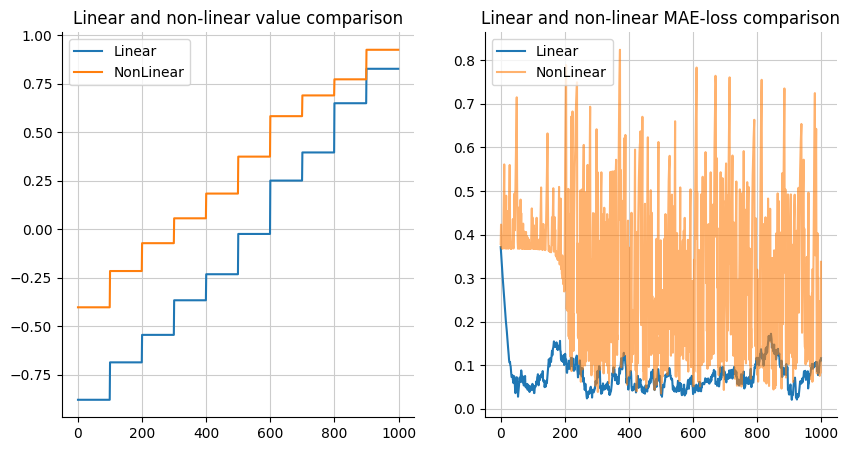

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax = plot_values(ax, "Linear", v_hat_linear, num_of_states=num_of_states, groups=groups)
ax = plot_values(ax, "NonLinear", v_hat_nonlinear, num_of_states=num_of_states, groups=groups)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(c='#ccc')
ax.set_title("Linear and non-linear value comparison")
ax.legend()

ax = plt.subplot(122)
ax.plot(linear_history, label='Linear')
ax.plot(nonlinear_history, label='NonLinear', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(c='#ccc')
ax.set_title("Linear and non-linear MAE-loss comparison")
ax.legend();

The convergence of value function approximation in reinforcement learning depends on the choice of the function approximator and the learning algorithm. In the case of linear function approximation with semi-gradient TD, convergence is generally guaranteed under certain conditions, such as a fixed policy and a sufficiently small step size. This is because the update direction aligns well with the true gradient, and the error surface is convex, allowing the algorithm to find a global minimum.

However, when using non-linear function approximators like neural networks, the error surface becomes non-convex, and the semi-gradient TD update may not point in a direction that reduces the true error. This can lead to divergence or oscillations, especially when the target policy is non-stationary or the learning rate is too high. The non-stationarity of the target, which changes as the value function updates, further complicates convergence. As a result, non-linear semi-gradient TD does not guarantee convergence and may fail to learn a stable value function.

Each algorithmic enhancement, such as using linear approximators, mini-batch updates, or experience replay, aims to improve stability and convergence. Linear methods benefit from theoretical guarantees, while mini-batch and replay buffer techniques help by smoothing updates and breaking correlations in the data, which can mitigate but not fully resolve the convergence issues inherent to non-linear function approximation.

## Mini-batch Semi-gradient TD

In [9]:
def train_ann(
    v_hat:nn.Module,
    env:RandomWalk,
    groups:int,
    num_of_states:int,
    episodes:int=1,
    gamma:float=1.0,
    alpha:float=0.001,
    gt:np.ndarray=None,
    batch_size:int=1,
):
    history = []
    buffer =[]
    with tqdm(range(episodes), leave=True) as pbar:
        for episode in pbar:
            state = env.reset()['state']
            state = get_features(state, groups, num_of_states)
            
            while not env.is_terminated():
                action = int(np.random.choice([0, 1]))
                feedback = env.step(action)
                new_state = get_features(feedback['state'], groups, num_of_states)
                reward = torch.tensor(feedback['reward'])
                reward = reward.reshape((1, 1))
                buffer.append({'state':state, 'new_state':new_state, 'reward':reward, 'terminated': env.is_terminated()})

                if len(buffer) != batch_size: 
                    state = new_state.detach()
                    continue

                total_loss = 0
                for item in buffer:
                    if not item['terminated']:
                        target = item['reward'] + gamma * v_hat(item['new_state'])
                        target = target.detach()
                    else:
                        target = item['reward']
                    total_loss += 0.5 * torch.float_power(target - v_hat(item['state']), 2)

                v_hat.zero_grad()
                total_loss.backward()

                # Take the gradient
                with torch.no_grad():
                    for w in v_hat.parameters():
                        if w.grad is not None:
                            w.copy_(w - alpha * w.grad)
                state = new_state.detach()
                buffer.clear()

            if gt is not None:
                states = torch.arange(0, num_of_states)
                per_group = num_of_states // groups
                states = (states // per_group)
                features = torch.eye(groups)[states]
                values = v_hat(features).detach().numpy()
                mae = np.abs(values[:, 0] - gt)
                history.append(mae.mean())


    return v_hat, history


In [10]:
num_of_states = 1000
episodes = 1000
alpha = 0.1
groups = 10
gt = np.load("gt.npy")
v_hat_b4 = V_hat(groups)
random_walk = RandomWalk(num_of_states)
v_hat_b4, history_b4 = train_ann(
    v_hat=v_hat_b4,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=episodes,
    gamma=1.0,
    alpha=alpha,
    gt=gt,
    batch_size=4
)

v_hat_b8 = V_hat(groups)
v_hat_b8, history_b8 = train_ann(
    v_hat=v_hat_b8,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=episodes,
    gamma=1.0,
    alpha=alpha,
    gt=gt,
    batch_size=8
)

v_hat_b16 = V_hat(groups)
v_hat_b16, history_b16 = train_ann(
    v_hat=v_hat_b16,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=episodes,
    gamma=1.0,
    alpha=alpha,
    gt=gt,
    batch_size=16
)

v_hat_b32 = V_hat(groups)
v_hat_b32, history_b32 = train_ann(
    v_hat=v_hat_b32,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=episodes,
    gamma=1.0,
    alpha=alpha,
    gt=gt,
    batch_size=32
)

100%|██████████| 1000/1000 [00:39<00:00, 25.30it/s]


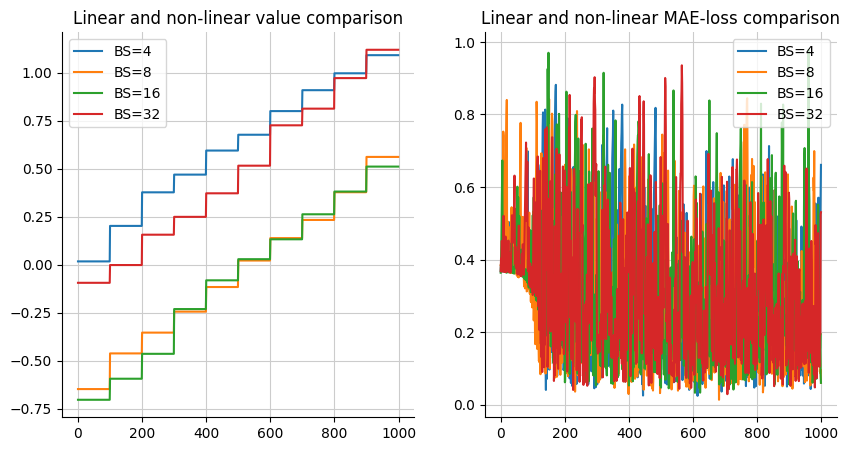

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax = plot_values(ax, "BS=4", v_hat_b4, num_of_states=num_of_states, groups=groups)
ax = plot_values(ax, "BS=8", v_hat_b8, num_of_states=num_of_states, groups=groups)
ax = plot_values(ax, "BS=16", v_hat_b16, num_of_states=num_of_states, groups=groups)
ax = plot_values(ax, "BS=32", v_hat_b32, num_of_states=num_of_states, groups=groups)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(c='#ccc')
ax.set_title("Linear and non-linear value comparison")
ax.legend()

ax = plt.subplot(122)
ax.plot(history_b4, label='BS=4')
ax.plot(history_b8, label='BS=8')
ax.plot(history_b16, label='BS=16')
ax.plot(history_b32, label='BS=32')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(c='#ccc')
ax.set_title("Linear and non-linear MAE-loss comparison")
ax.legend();

Mini-batch semi-gradient TD introduces batch updates, which can help stabilize learning by averaging the gradients over multiple transitions. This reduces the variance of updates and can make the learning process less sensitive to the noise inherent in individual transitions. While this approach can improve the stability of training and sometimes help with convergence, it does not fundamentally resolve the issues caused by non-linear function approximation. The underlying non-convexity and moving target problem remain, so convergence is still not guaranteed, but the learning process may become more robust and less prone to divergence in practice.

## Experience Replay

In [12]:
class ExperienceReplay:
    def __init__(self, capacity:int=10000):
        self.buffer = collections.deque(maxlen=capacity)

    def insert(
        self,
        state:torch.Tensor,
        reward:torch.Tensor,
        next_state:torch.Tensor,
        done:torch.Tensor,
    ):
        self.buffer.append((state, reward, next_state, done))

    def sample(self, batch_size:int=32):
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, rewards, next_states, dones = zip(*batch)

        states = torch.concat(states, dim=0)
        rewards = torch.concat(rewards, dim=0)
        next_states = torch.concat(next_states, dim=0)
        dones = torch.concat(dones, dim=0)

        return states, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

In [13]:
def train_ann(
    v_hat:nn.Module,
    env:RandomWalk,
    groups:int,
    num_of_states:int,
    episodes:int=1,
    gamma:float=1.0,
    alpha:float=0.1,
    gt:np.ndarray=None,
    replay_buffer_capacity:int=10000,
    min_capacity:int=100,
    batch_size:int=32
):
    replay_buffer = ExperienceReplay(replay_buffer_capacity)
    history = []
    with tqdm(range(episodes), leave=True) as pbar:
        for episode in pbar:
            state = env.reset()['state']
            state = get_features(state, groups, num_of_states)
            
            while not env.is_terminated():
                action = int(np.random.choice([0, 1]))
                feedback = env.step(action)
                new_state = get_features(feedback['state'], groups, num_of_states)
                reward = torch.tensor(feedback['reward'])
                reward = reward.reshape((1, 1))
                done = torch.zeros((1, 1))
                if env.is_terminated():
                    done[0, 0] = 1.0

                replay_buffer.insert(
                    state=state,
                    reward=reward,
                    next_state=new_state,
                    done=done
                )

                if len(replay_buffer) < min_capacity:
                    state = new_state.detach()
                    continue
                
                b_state, b_reward, b_new_state, b_done = replay_buffer.sample(batch_size)

                target = b_reward + gamma * v_hat(b_new_state) * (1 - b_done)
                target = target.detach()
                loss = 0.5 * torch.float_power(target - v_hat(b_state), 2)
                loss = loss.mean()
                v_hat.zero_grad()
                loss.backward()

                # Take the gradient
                with torch.no_grad():
                    for w in v_hat.parameters():
                        if w.grad is not None:
                            w.copy_(w - alpha * w.grad)
                state = new_state.detach()

            if gt is not None:
                states = torch.arange(0, num_of_states)
                per_group = num_of_states // groups
                states = (states // per_group)
                features = torch.eye(groups)[states]
                values = v_hat(features).detach().numpy()
                mae = np.abs(values[:, 0] - gt)
                history.append(mae.mean())


    return v_hat, history


In [14]:
num_of_states = 1000
episodes = 1000
alpha = 0.3
groups = 10
gt = np.load("gt.npy")
v_hat_b4 = V_hat(groups)
random_walk = RandomWalk(num_of_states)
v_hat_b4, history_b4 = train_ann(
    v_hat=v_hat_b4,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=episodes,
    gamma=1.0,
    alpha=alpha,
    gt=gt,
    batch_size=4
)

v_hat_b8 = V_hat(groups)
v_hat_b8, history_b8 = train_ann(
    v_hat=v_hat_b8,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=episodes,
    gamma=1.0,
    alpha=alpha,
    gt=gt,
    batch_size=8
)

v_hat_b16 = V_hat(groups)
v_hat_b16, history_b16 = train_ann(
    v_hat=v_hat_b16,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=episodes,
    gamma=1.0,
    alpha=alpha,
    gt=gt,
    batch_size=16
)

v_hat_b32 = V_hat(groups)
v_hat_b32, history_b32 = train_ann(
    v_hat=v_hat_b32,
    env=random_walk,
    groups=groups,
    num_of_states=num_of_states,
    episodes=episodes,
    gamma=1.0,
    alpha=alpha,
    gt=gt,
    batch_size=32
)

100%|██████████| 1000/1000 [01:32<00:00, 10.82it/s]


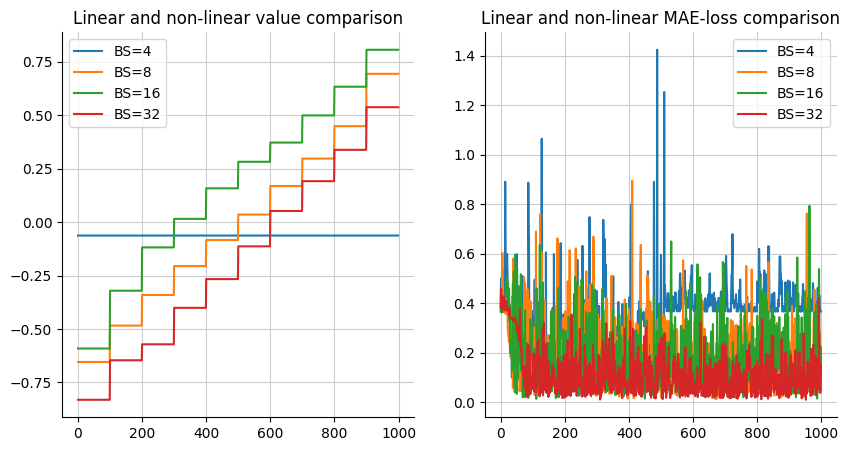

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax = plot_values(ax, "BS=4", v_hat_b4, num_of_states=num_of_states, groups=groups)
ax = plot_values(ax, "BS=8", v_hat_b8, num_of_states=num_of_states, groups=groups)
ax = plot_values(ax, "BS=16", v_hat_b16, num_of_states=num_of_states, groups=groups)
ax = plot_values(ax, "BS=32", v_hat_b32, num_of_states=num_of_states, groups=groups)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(c='#ccc')
ax.set_title("Linear and non-linear value comparison")
ax.legend()

ax = plt.subplot(122)
ax.plot(history_b4, label='BS=4')
ax.plot(history_b8, label='BS=8')
ax.plot(history_b16, label='BS=16')
ax.plot(history_b32, label='BS=32')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(c='#ccc')
ax.set_title("Linear and non-linear MAE-loss comparison")
ax.legend();

Experience replay further enhances convergence properties by allowing the algorithm to break the temporal correlations present in sequential data. By sampling random batches from a buffer of past experiences, the updates become more independent and representative of the overall state space. This can help smooth out learning, reduce variance, and prevent the network from overfitting to recent transitions. While experience replay is especially beneficial for stabilizing training in deep reinforcement learning, it still does not guarantee convergence when using non-linear function approximators. However, it often leads to more reliable and consistent learning in practice by mitigating some of the instability issues.